# General data analysis

Idea: test on jupyternotebok and then create final function to run using a for loop on both dataset

NB: inspired by the events_analysis.py from MRP

## Initialization

In [1]:
import json
import math
import random
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys


In [2]:
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    

print(project_root)

c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub


In [3]:
from event_model import event_model as em
import data_analysis.event_generator as eg
from algorithms import clustering
from algorithms.clustering import Clustering
from validator.validator_lite import MCParticle

In [4]:
def data_distribution(data):
    total = 0
    for num in data:
        total += num

    mu = total / len(data)

    aux = 0
    for num in data:
        aux += ((num - mu) ** 2)

    variance = aux / len(data)
    sigma = math.sqrt(variance)

    print(f'Mean: {mu}')
    print(f'Variance: {variance}')
    print(f'Standard deviation: {sigma}')

    return mu, variance, sigma

In [153]:
def plot_distribution(mu, sigma, title='Distribution', xlabel='Data',safe_to_file=False):
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label='pdf')
    plt.title(title)
    plt.text(-0.0008, -0.0008, f'$\mu={round(mu, 4)},\ \sigma={round(sigma, 4)}$')
    plt.grid(True)
    plt.xlabel(xlabel)
    
    # set x-axis limits to full range of distribution
    plt.xlim(mu - 4 * sigma, mu + 4 * sigma)
    
    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()

In [88]:
def get_bins(x):
    q25, q75 = np.percentile(x, [.25, .75])
    bin_width = 2 * (q75 - q25) * len(x) ** (-1 / 3)
    bins = round((x.max() - x.min()) / bin_width)
    print("Freedman–Diaconis number of bins:", bins)
    return bins

In [147]:
def plot_density_histogram(data, title="Histogram", xlabel="Data", ylabel="", safe_to_file=False):
    x = np.array(data)
    counts, bins, _ = plt.hist(x, bins=100, color='skyblue', alpha=0.5, edgecolor='blue'
                               #, label='# of hits', bins = get_bins(x)
                               )
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True, color='grey', linewidth=0.5)
    plt.title(title)

    kde_xs = np.linspace(np.min(x), np.max(x), 300)
    kde = stats.gaussian_kde(x)
    plt.plot(kde_xs, kde.pdf(kde_xs) * len(x) * np.diff(bins)[0], label="Gaussian distribution")

    plt.legend(loc="upper right")
    plt.tight_layout()

    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()

In [148]:
def plot_histogram(data, title="Histogram", xlabel="Data", ylabel="", safe_to_file=False):
    x = np.array(data)
    plt.hist(x, 100, color='skyblue', alpha=0.5, edgecolor='blue')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True, color='grey', linewidth=0.5)
    plt.title(title)
    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()

## 1. Number of hits by events (total, pur, noisy)

In [144]:
def get_json_data_from_folder(data_set_folder):
    jsons = []
    # for (dirpath, dirnames, filenames) in os.walk(f"../events/{data_set_folder}"):
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(project_root, f"datasets/{data_set_folder}")):
        filenames = sorted(filenames, key=lambda filename: int(filename.replace('velo_event_', '').replace('.json', '')))
        for i, filename in enumerate(filenames):
            # Get an event
            # print(f'opening: {filename}')
            f = open(os.path.realpath(os.path.join(dirpath, filename)))
            json_data = json.loads(f.read())
            event = em.event(json_data)
            f.close()
            # print(f'closing : {filename}')

            jsons.append(json_data)
    return jsons

In [7]:
jsons = get_json_data_from_folder('minibias')


In [8]:
print(len(jsons))

995


In [10]:
def tracks_from_data(json_data, only_reconstructible=True):
    reconstructible_tracks = []
    hits = []
    counter = 0
    for hid, (x, y, z) in enumerate(zip(json_data["x"], json_data["y"], json_data["z"])):
        hits.append(em.hit(x, y, z, hid))
        
    description = json_data["montecarlo"]["description"]
    particles = json_data["montecarlo"]["particles"]

    for p in particles:
        d = {description[i]: p[i] for i in range(len(description))}
        track_hits = [hits[hit_number] for hit_number in d["hits"]]
        
        if only_reconstructible:
            if len(track_hits) >= 3:
                reconstructible_tracks.append(em.track(track_hits))
        else:
            reconstructible_tracks.append(em.track(track_hits))

    return reconstructible_tracks, hits

In [11]:
reconstructible_tracks_list = []
hits_list = []
nr_hits_list = []
for event in jsons:
    tracks, hits = tracks_from_data(event, True)
    reconstructible_tracks_list.append(tracks)
    hits_list.append(hits)
    nr_hits_list.append(len(hits))


In [13]:
#print(nr_hits_list)

> total number of hits in the event

In [15]:
total = 0
for num in nr_hits_list:
    total += num
print(total)

1954057


In [16]:
mu, var, sigma = data_distribution(nr_hits_list)

Mean: 1963.8763819095477
Variance: 1208248.6389899263
Standard deviation: 1099.2036385447086


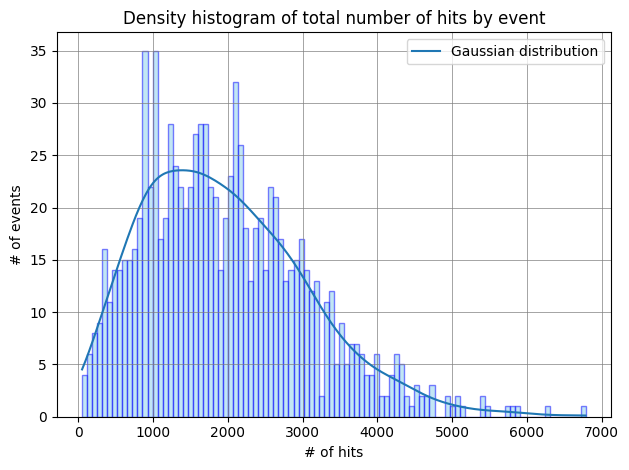

In [151]:
plot_density_histogram(nr_hits_list, title="Density histogram of total number of hits by event", xlabel="# of hits", ylabel="# of events", safe_to_file=False)

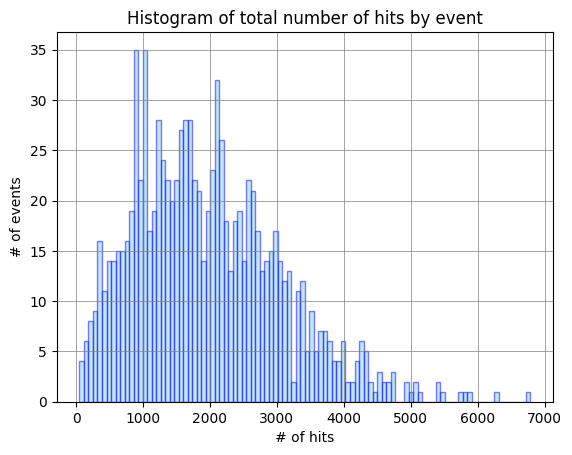

In [145]:
plot_histogram(nr_hits_list, title="Histogram of total number of hits by event", xlabel="# of hits", ylabel="# of events", safe_to_file=False)

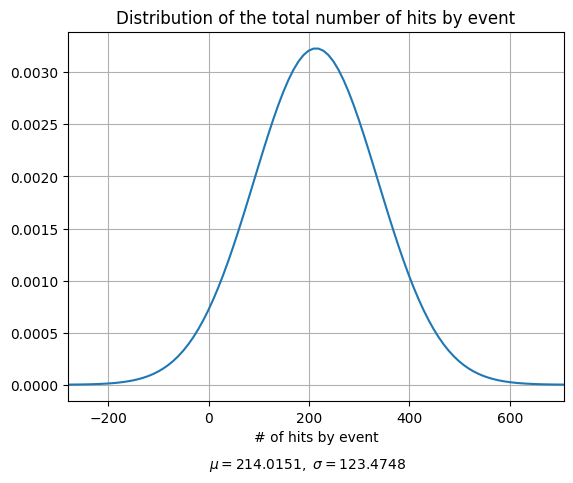

In [158]:
plot_distribution(mu, sigma, title='Distribution of the total number of hits by event', xlabel = '# of hits by event',safe_to_file=False)

In [84]:
def plot_density_histogram(data, title="Histogram", xlabel="Data", ylabel="", safe_to_file=False):
    x = np.array(data)
    plt.hist(x, density=True, bins=get_bins(x), label="Data")

    mn, mx = plt.xlim()
    plt.xlim(mn, mx)
    kde_xs = np.linspace(mn, mx, 300)
    kde = stats.gaussian_kde(x)
    plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")

    plt.legend(loc="upper left")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()

## Noise


In [43]:
def noise_from_data(json_data,only_reconstructible=True):
    noise = 0
    hits_in_reconstructible_tracks = 0
    tracks = []
    hits = []
    for hid, (x, y, z) in enumerate(zip(json_data["x"], json_data["y"], json_data["z"])):
        hits.append(em.hit(x, y, z, hid))


    description = json_data["montecarlo"]["description"]
    particles = json_data["montecarlo"]["particles"]

    for p in particles:
        d = {description[i]: p[i] for i in range(len(description))}
        track_hits = [hits[hit_number] for hit_number in d["hits"]]

        if only_reconstructible:
            if len(track_hits) >= 3:
                hits_in_reconstructible_tracks += len(track_hits)
        else:
            hits_in_reconstructible_tracks += len(track_hits)

    noise = len(hits) - hits_in_reconstructible_tracks
    return noise

In [44]:
nr_noise_list = []
for event in jsons:
    noise = noise_from_data(event,True)
    nr_noise_list.append(noise)

In [45]:
print(len(nr_noise_list))
print((nr_noise_list[2]))

995
5


> number of noise hits in the event

In [46]:
mu, var, sigma =data_distribution(nr_noise_list)

Mean: 214.01507537688443
Variance: 15246.028918461674
Standard deviation: 123.47481086627214


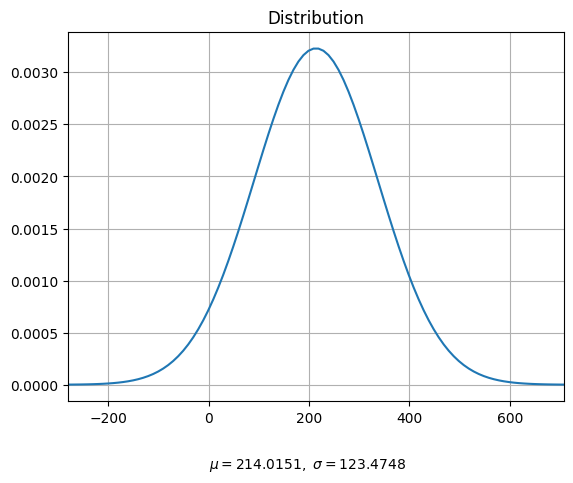

In [83]:
plot_distribution(mu, sigma, title='Distribution', safe_to_file=False)

In [122]:
total_hits = sum(nr_hits_list)
total_noise = sum(nr_noise_list)
percentage= total_noise/total_hits
print(percentage)

0.10897583847349386


## 2. Number of tracks by event

In [156]:
reconstructible_tracks_list = []
nr_recon_tracks_list = []

for event in jsons:
    tracks, hits = tracks_from_data(event, True)
    reconstructible_tracks_list.append(tracks)
    hits_list.append(hits)
    nr_recon_tracks_list.append(len(tracks))

In [158]:
print(len(nr_recon_tracks_list))
print(nr_recon_tracks_list)

995
[153, 343, 13, 463, 305, 431, 397, 134, 94, 436, 271, 373, 169, 179, 152, 28, 283, 181, 170, 564, 104, 23, 83, 226, 450, 130, 280, 96, 161, 407, 96, 406, 145, 351, 148, 47, 104, 109, 72, 73, 376, 87, 274, 183, 589, 288, 189, 157, 315, 192, 238, 193, 298, 156, 628, 220, 434, 222, 211, 240, 315, 112, 341, 445, 230, 57, 502, 399, 387, 524, 56, 210, 169, 178, 75, 265, 220, 192, 652, 212, 553, 52, 60, 37, 308, 408, 237, 398, 173, 484, 159, 306, 218, 325, 347, 305, 107, 429, 91, 300, 119, 337, 404, 251, 183, 283, 207, 216, 452, 194, 196, 329, 148, 195, 339, 258, 148, 196, 153, 453, 276, 40, 229, 330, 364, 70, 279, 259, 624, 74, 602, 807, 169, 156, 173, 248, 474, 153, 148, 275, 293, 229, 126, 117, 224, 451, 161, 453, 20, 278, 384, 80, 381, 400, 385, 230, 253, 125, 484, 274, 444, 64, 95, 337, 276, 530, 250, 289, 313, 232, 478, 177, 574, 520, 264, 421, 336, 106, 362, 68, 164, 209, 497, 125, 288, 302, 387, 213, 673, 402, 156, 45, 123, 99, 87, 246, 144, 46, 349, 353, 404, 66, 388, 202, 702, 3

In [159]:
mu, var, sigma = data_distribution(nr_recon_tracks_list)

Mean: 274.2733668341709
Variance: 23791.503160021166
Standard deviation: 154.24494533053965


In [ ]:
# create a normal distribution using numpy
x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean)/sigma)**2)

# plot the normal distribution using matplotlib
plt.plot(x, y)
plt.axvline(x=mean, color='r', linestyle='--')  # vertical line at the mean
plt.axvline(x=mean+sigma, color='g', linestyle='--')  # vertical line at mean+sigma
plt.axvline(x=mean-sigma, color='g', linestyle='--')  # vertical line at mean-sigma
plt.xlabel('Variable')
plt.ylabel('Density')
plt.title('Normal Distribution')
plt.show()

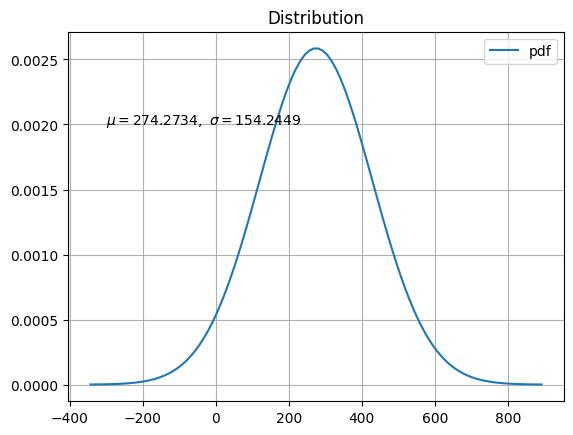

In [160]:
plot_distribution(mu, sigma, title='Distribution', safe_to_file=False)

## 3. Number of hits by tracks (total = length, normal and noisy hits distribution)

## 4. Histogram with distribution of total number of hits by module + noise hits by module (MRP txt + histogram somewhere in the code)